In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
from scipy.stats import spearmanr
import tifffile as tf
from false_positive_analysis import percent_false_positive
%config InlineBackend.figure_format='retina'

# Look at false positive rate

In [2]:
#read in threshold mtx
#do you want to look at deepcell dots or daostar
deepcell = True
channel = 4

if deepcell == False:
    thresh_mtx = []
    for i in range(11):
        ch_mtx = pd.read_csv(f"/groups/CaiLab/personal/Lex/raw/031322_11kgenes_experiment/notebook_pyfiles/genebycell/Threshold_{i}/comb_genebycell_{channel}.csv", index_col=0)
        #cells above 1000 total counts
        ch_mtx = ch_mtx.T
        ch_mtx = ch_mtx[ch_mtx.sum(axis=1)>1000].T
        thresh_mtx.append(ch_mtx)

else:
    mtx = pd.read_csv(f"/groups/CaiLab/personal/Lex/raw/031322_11kgenes_experiment/notebook_pyfiles/genebycell/min3_min3/final/genebycell_{channel}.csv", index_col=0)
    mtx = mtx.T
    mtx = mtx[mtx.sum(axis=1)>1000].T

In [3]:
#read in rnaseq data
rnaseq_1 = pd.read_csv("./RNAseq_files/nih3t3_FPKM.csv")
rnaseq_2 = pd.read_csv("./RNAseq_files/kallisto_NIH3T3.csv")
#rnaseq= rnaseq[["tracking_id","E14J B1"]]
rnaseq_1.columns = ["Genes","FPKM"]

In [4]:
#codebook
codebook = pd.read_csv("/groups/CaiLab/personal/Lex/raw/031322_11kgenes_experiment/barcode_key/codebook_string_488.csv", index_col=0)
#codebook.columns = ["Gene", "Brcd1", "Brcd2"]

In [5]:
#separate into true and false codebook
fakebook = codebook[codebook.index.str.startswith("fake")]
codebook = codebook.drop(fakebook.index)

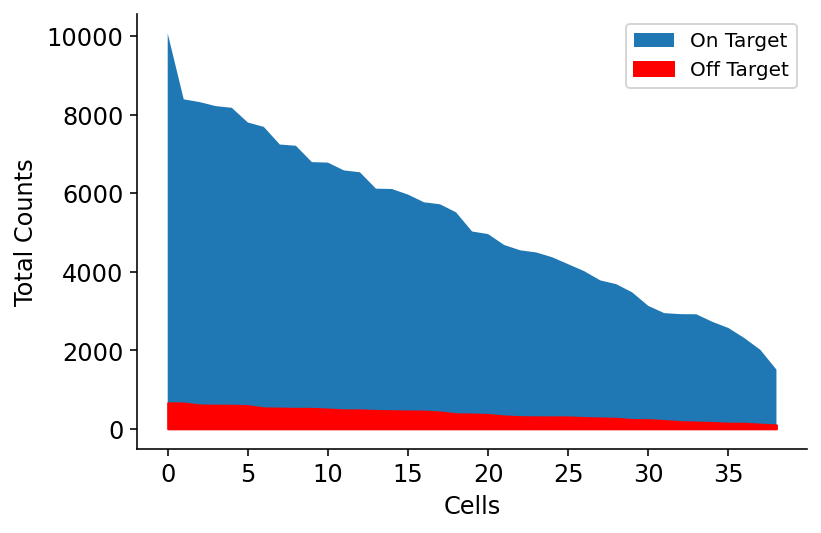

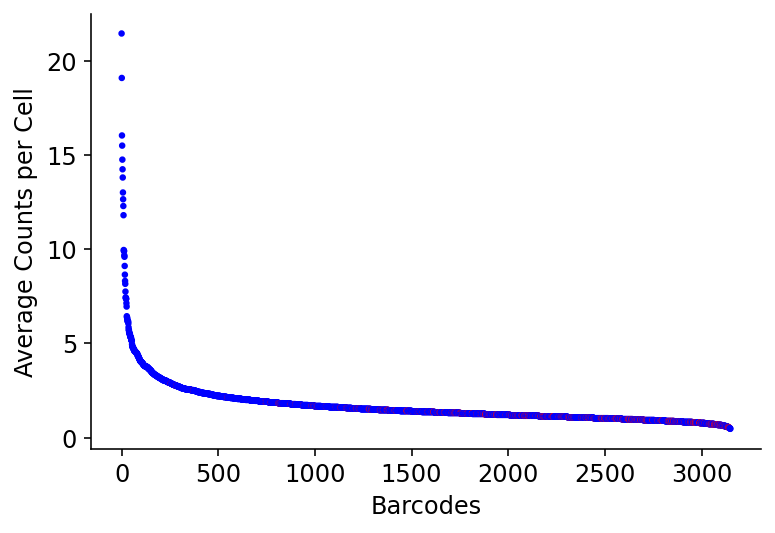

,percent fp,false positive rate,mean counts,total sum
0,0.070956,0.621034,5264.384615,205311.0


In [6]:
#calculate false positive
if deepcell == False:
    fp_list = []
    for i in range(11):
        fp, fake, norm_fpr= percent_false_positive(thresh_mtx[i], codebook, fakebook)
        percent_fp = fp["FP raw"].mean()
        mean_counts = fp["total_counts"].mean()
        sum_counts = fp["total_counts"].sum()
        fp_list.append([percent_fp,norm_fpr,mean_counts,sum_counts])
else:
    fp_list = []
    fp, fake, norm_fpr= percent_false_positive(mtx, codebook, fakebook)
    percent_fp = fp["FP raw"].mean()
    mean_counts = fp["total_counts"].mean()
    sum_counts = fp["total_counts"].sum()
    fp_list.append([percent_fp,norm_fpr,mean_counts,sum_counts])

#conver to df
df_stats = pd.DataFrame(fp_list)
df_stats.columns = ["percent fp","false positive rate","mean counts", "total sum"]
df_stats

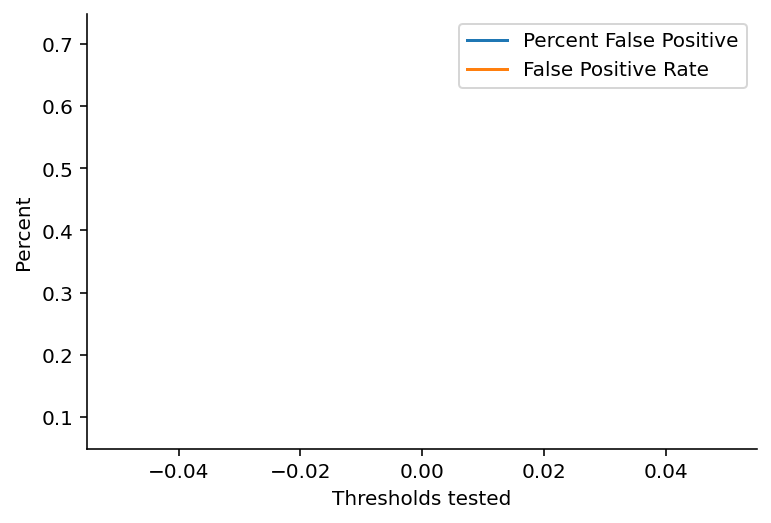

In [8]:
#plot fpr and percent falsepsotive
plt.plot(df_stats["percent fp"], label = "Percent False Positive")
plt.plot(df_stats["false positive rate"], label = "False Positive Rate")
plt.ylabel("Percent")
plt.xlabel("Thresholds tested")
sns.despine()
plt.legend()

In [ ]:
#plot average counts
plt.plot(df_stats["mean counts"])
plt.ylabel("Mean Total Counts")
plt.xlabel("Thresholds tested")
sns.despine()
plt.legend()

# Percent decoded by cells

In [7]:
def keep_dots_in_cells(mask, dot_locations):
    """
    A function to remove any dots outside of mask
    Parameter
    ---------
    mask = cellpose generated mask path
    dot_locations = dot_locations path
    """
    
    #read in data
    locations = pd.read_csv(dot_locations)
    #cellpose mask outputs (c,y,x)
    img = tf.imread(mask)
    #get x and y coordinates
    locations_xy = locations[["x","y"]].values.astype(int)
    dot_info = []
    #keep dots only in cells
    for i in range(len(locations)):
        x = locations_xy[i][0]
        y = locations_xy[i][1]
        if img[y,x] == 0:
            continue
        else:
            cell = img[y,x]
            dot_info.append([i,cell])
            
    dot_info = np.array(dot_info)
    
    #keep rows that have cells
    dots_in_cells = locations.loc[dot_info[:,0]]
    
    #add cell info
    dots_in_cells["cell number"] = dot_info[:,1]
    
    return dots_in_cells

In [8]:
#read in files
pos_list=[15,39,52,88,95]
percent_decoded = []
for pos in pos_list:
    dots_used_locations = f"/groups/CaiLab/personal/Lex/raw/031322_11kgenes_experiment/notebook_pyfiles/decoded/deepcell_min3_min3/Channel_{channel}/Pos{pos}/dots_used_z_0.csv"
    dots_unused_locations = f"/groups/CaiLab/personal/Lex/raw/031322_11kgenes_experiment/notebook_pyfiles/decoded/deepcell_min3_min3/Channel_{channel}/Pos{pos}/dots_unused_z_0.csv"
    mask = f"/groups/CaiLab/personal/Lex/raw/031322_11kgenes_experiment/notebook_pyfiles/edges_deleted/MMStack_Pos{pos}.tif"
    dots_used = keep_dots_in_cells(mask, dots_used_locations)
    dots_unused = keep_dots_in_cells(mask, dots_unused_locations)
    percent = len(dots_used)/(len(dots_used)+len(dots_unused[dots_unused["hyb"]!= 45]))
    percent_decoded.append(percent)

In [9]:
np.mean(percent_decoded)

0.20658008197405642

# RNA seq correlations

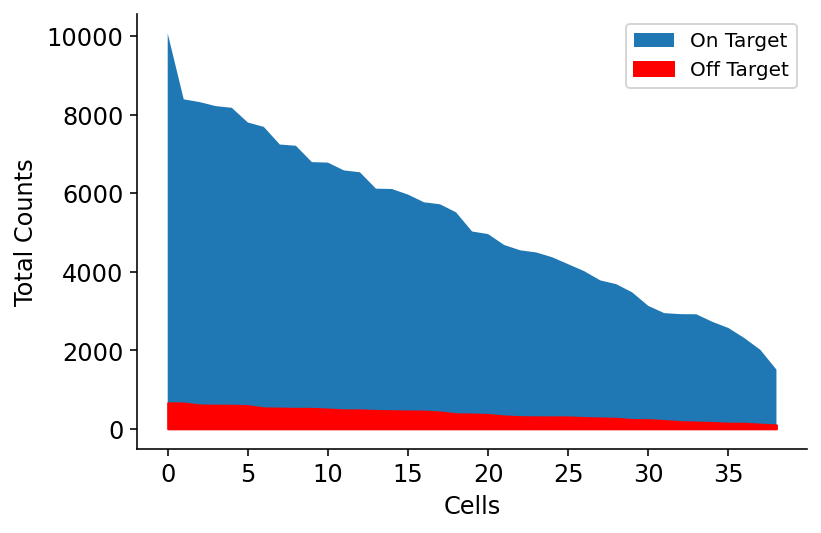

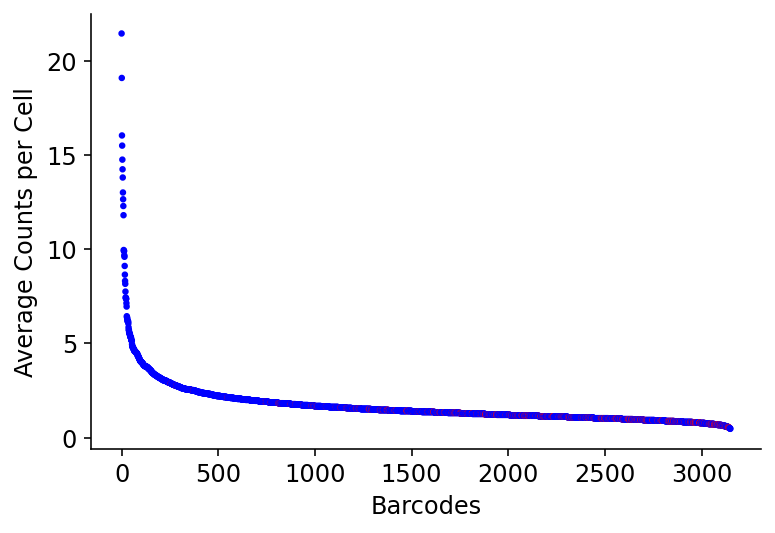

In [10]:
# #choose desired threshold
# threshold = 6

# fp, fake, norm_fpr= percent_false_positive(thresh_mtx[threshold], codebook, fakebook)
fp, fake, norm_fpr= percent_false_positive(mtx, codebook, fakebook)

In [11]:
#convert data to pseudobulk rnaseq data
if deepcell == False:
    bulk = pd.DataFrame(thresh_mtx[threshold].mean(axis=1)).reset_index()
    bulk.columns = ["Genes", "Counts"]
else:
    bulk = pd.DataFrame(mtx.mean(axis=1)).reset_index()
    bulk.columns = ["Genes", "Counts"]

In [12]:
#rename rnaseq columns and lowercase
rnaseq_1["Genes"]=rnaseq_1["Genes"].str.lower()
rnaseq_2["gene"]=rnaseq_2["gene"].str.lower()

In [13]:
rnaseq_2.columns = ["Genes","TPM"]

In [14]:
#merge
comb_1 = pd.merge(rnaseq_1,bulk)

In [15]:
#pearson calc old rnaseq
linreg = linregress(x = comb_1["FPKM"], y = comb_1["Counts"])
pearsonr = linreg[2]
pearsonr = round(pearsonr,2)
pearsonr

0.71

In [16]:
comb_1.sort_values("Counts", ascending=False)

,Genes,FPKM,Counts
319,bgn,995.140000,21.435897
1479,myh9,120.497000,19.076923
274,axl,204.019000,16.025641
765,emp1,260.981000,15.487179
2500,trim28,133.218000,14.743590
...,...,...,...
1615,oc90,0.000000,0.512821
590,cyp11a1,0.000000,0.487179
2652,wnt16,0.020993,0.487179
753,elavl4,0.017176,0.487179


In [17]:
comb_1["Log Counts"] = np.log2(comb_1["Counts"]+0.1)
comb_1["Log FPKM"] = np.log2(comb_1["FPKM"]+0.1)

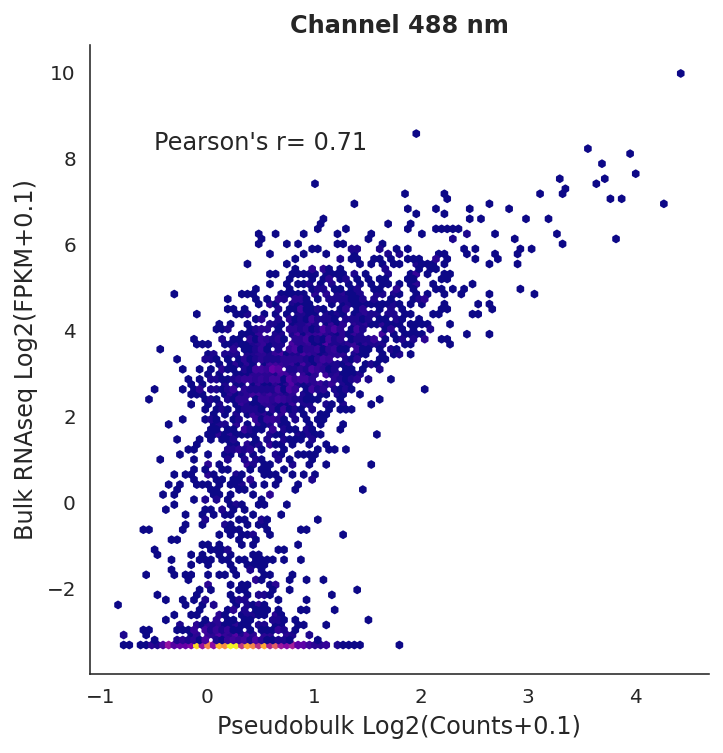

In [18]:
sns.set_style("white")
joint_kws=dict(gridsize=100)
hexplot = sns.jointplot(data=comb_1, x="Log Counts", y="Log FPKM", kind="hex",mincnt=0.1, 
              cmap="plasma", dropna=True, joint_kws=joint_kws)
plt.ylabel("Bulk RNAseq Log2(FPKM+0.1)", fontsize=12)
plt.xlabel("Pseudobulk Log2(Counts+0.1)", fontsize=12)
hexplot.ax_marg_x.remove()
hexplot.ax_marg_y.remove()
plt.annotate(f"Pearson's r= {pearsonr}", (-0.5,8.2), fontsize=12)
plt.title("Channel 488 nm", fontweight="bold")
sns.despine()

In [19]:
#read in smfish 
smfish = pd.read_csv("./smFISH_results.csv")

In [20]:
#convert to pseudobulk results 
smfish_df = pd.DataFrame(smfish.T.mean(axis=1))
smfish_df = smfish_df.reset_index()
smfish_df.columns = ["Genes", "smFISH Counts"]
smfish_df["Genes"] = smfish_df["Genes"].str.lower()

In [21]:
#combine smfish pseudobulk and seqfish+ pseudobulk results
comb_2 = pd.merge(smfish_df,bulk)

In [22]:
#pearson calc smfish results 
linreg = linregress(x = comb_2["smFISH Counts"], y = comb_2["Counts"])
pearsonr = linreg[2]
slope = linreg[0]
pearsonr = round(pearsonr,2)
print(f"smFISH correlation = {pearsonr}, efficiency = {round(slope,2)}")

smFISH correlation = 0.94, efficiency = 0.09


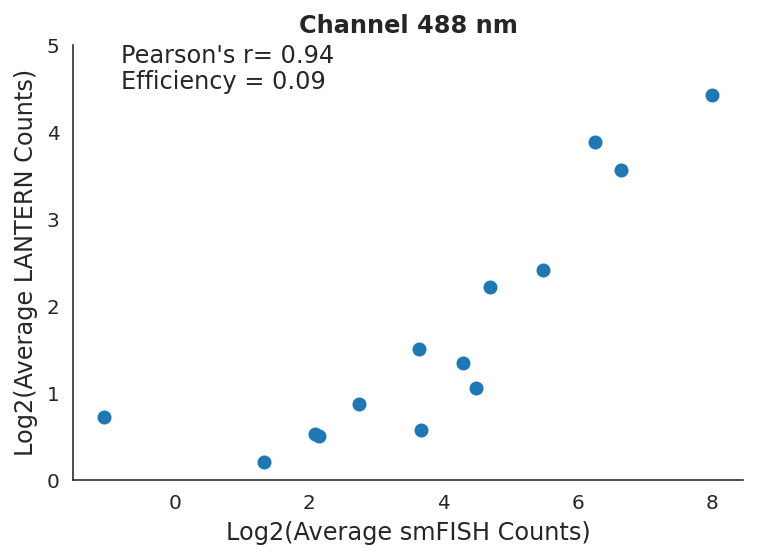

In [23]:
#plot correlation and efficiency
plt.scatter(x = np.log2(comb_2["smFISH Counts"]), y = np.log2(comb_2["Counts"]))
plt.xlabel("Log2(Average smFISH Counts)", fontsize=12)
plt.ylabel("Log2(Average LANTERN Counts)", fontsize=12)
plt.ylim(0,5)
plt.annotate(f"Pearson's r= {pearsonr}", (-0.8,4.8), fontsize=12)
plt.annotate(f"Efficiency = {round(slope,2)}", (-0.8,4.5), fontsize=12)
plt.title("Channel 488 nm", fontweight="bold")
sns.despine()